In [16]:
# Import module
import psycopg2
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
import statsmodels.api as sm


In [2]:
# Connect DataBase
connection = psycopg2.connect(user="omniostalent", password="omniostalent",
                                  host="aact-db.ctti-clinicaltrials.org",
                                  port="5432",
                                  database="aact")
cursor = connection.cursor()

In [3]:
# Load Data
studies = pd.read_sql_query('SELECT * FROM studies',con=connection)
sponsors = pd.read_sql_query('SELECT * FROM sponsors',con=connection)
conditions = pd.read_sql_query('SELECT * FROM conditions',con=connection)

In [4]:
# Clean studies
print(studies.shape)
studies_completed = studies[studies['overall_status'] == "Completed"]
print(studies_completed.shape)

(336145, 64)
(181198, 64)


In [5]:
# Clean sponsors
clean_sponsors = sponsors.loc[(sponsors.name == "University of Chicago") | (sponsors.name == "Novartis")]
clean_sponsors.head()

,id,nct_id,agency_class,lead_or_collaborator,name
332,3900884,NCT04315233,Industry,collaborator,Novartis
1898,3902726,NCT04300790,Industry,collaborator,Novartis
2444,3903325,NCT04295863,Other,lead,University of Chicago
2534,3903422,NCT04294966,Other,lead,University of Chicago
2896,3903830,NCT04291521,Other,collaborator,University of Chicago


In [6]:
# Merge Dataset
merge_1 = pd.merge(studies_completed, clean_sponsors, on="nct_id")
merge_1.shape

(1404, 68)

In [7]:
# Substet resu by featurer
for col in merge_1.columns: 
    print(col)
    
result_clean = merge_1[['name','study_first_submitted_date', 'nct_id', 'lead_or_collaborator']]
result_clean.head()

nct_id
nlm_download_date_description
study_first_submitted_date
results_first_submitted_date
disposition_first_submitted_date
last_update_submitted_date
study_first_submitted_qc_date
study_first_posted_date
study_first_posted_date_type
results_first_submitted_qc_date
results_first_posted_date
results_first_posted_date_type
disposition_first_submitted_qc_date
disposition_first_posted_date
disposition_first_posted_date_type
last_update_submitted_qc_date
last_update_posted_date
last_update_posted_date_type
start_month_year
start_date_type
start_date
verification_month_year
verification_date
completion_month_year
completion_date_type
completion_date
primary_completion_month_year
primary_completion_date_type
primary_completion_date
target_duration
study_type
acronym
baseline_population
brief_title
official_title
overall_status
last_known_status
phase
enrollment
enrollment_type
source
limitations_and_caveats
number_of_arms
number_of_groups
why_stopped
has_expanded_access
expanded_access_type

,name,study_first_submitted_date,nct_id,lead_or_collaborator
0,Novartis,2012-05-04,NCT01593748,collaborator
1,Novartis,2010-06-15,NCT01155817,collaborator
2,Novartis,2010-03-12,NCT01087008,collaborator
3,Novartis,2008-09-25,NCT00760981,collaborator
4,Novartis,2005-09-13,NCT00219739,collaborator


In [8]:
# group by
merge_1.groupby('name')[['name']].count()


,name
name,
Novartis,1055
University of Chicago,349


In [9]:
# Show value in column
print(result_clean['lead_or_collaborator'].unique())

['collaborator' 'lead']


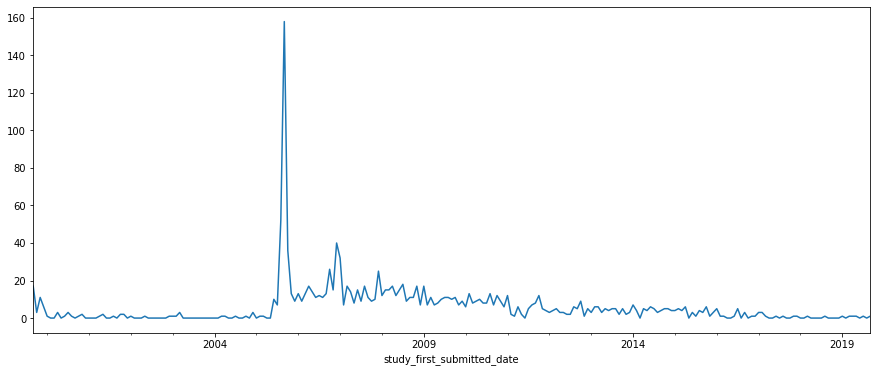

In [11]:
# Plot time serie
furniture = result_clean.groupby('study_first_submitted_date')['name'].count().reset_index()
furniture = furniture.set_index('study_first_submitted_date')
furniture.index = pd.to_datetime(furniture.index)

# By month
y = furniture['name'].resample('M').sum()

y.plot(figsize=(15, 6))
plt.show()

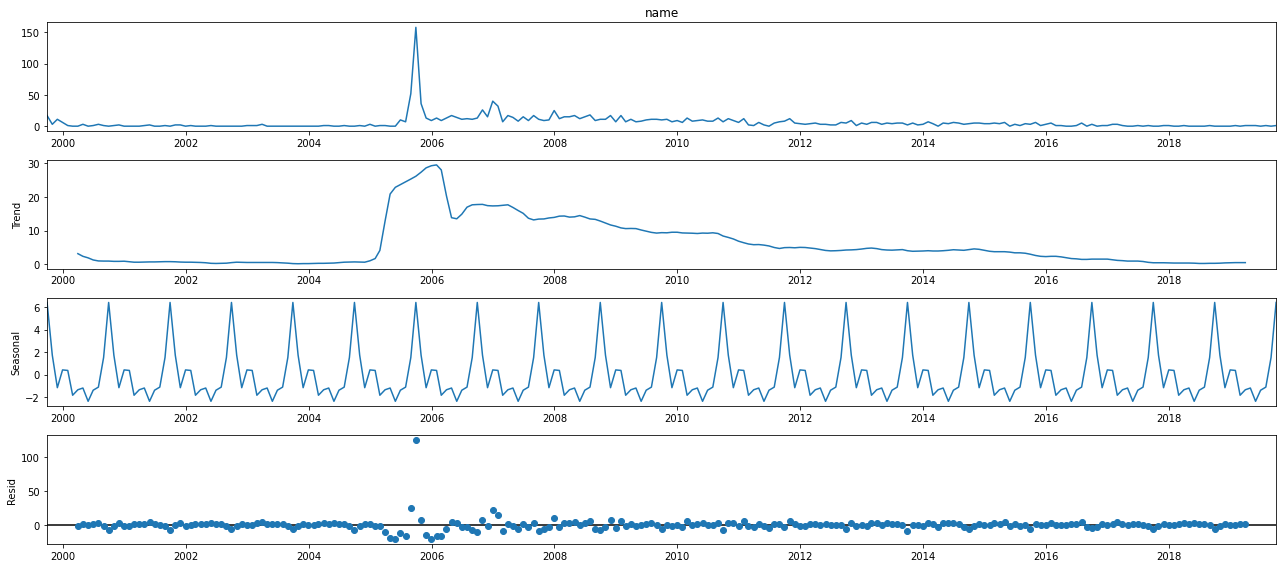

In [12]:
# Decompose Time Serie

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [18]:
# Found best parameters for ARIMA
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, 
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1926.9824478093356
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1826.0427088702204
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1910.8818572730088
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1734.2337726526653
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1825.3785674872884
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1812.853351381471
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1780.3172201842485
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1736.1751248982819
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1835.8253615249034
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1752.3566064859033
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1867.412525224654
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1669.9616559241204
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1764.2800266383429
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1749.8888475455483
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1738.073892016328
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1671.959346738407
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1857.3003629386503
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1776.3629063199

In [19]:
# Build ARIMA model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3997      0.065      6.108      0.000       0.271       0.528
ma.L1         -0.9296      0.058    -16.057      0.000      -1.043      -0.816
ar.S.L12      -0.0003      0.044     -0.006      0.995      -0.087       0.086
ma.S.L12      -1.0000      0.031    -32.045      0.000      -1.061      -0.939
sigma2       110.4457      0.000   3.91e+05      0.000     110.445     110.446


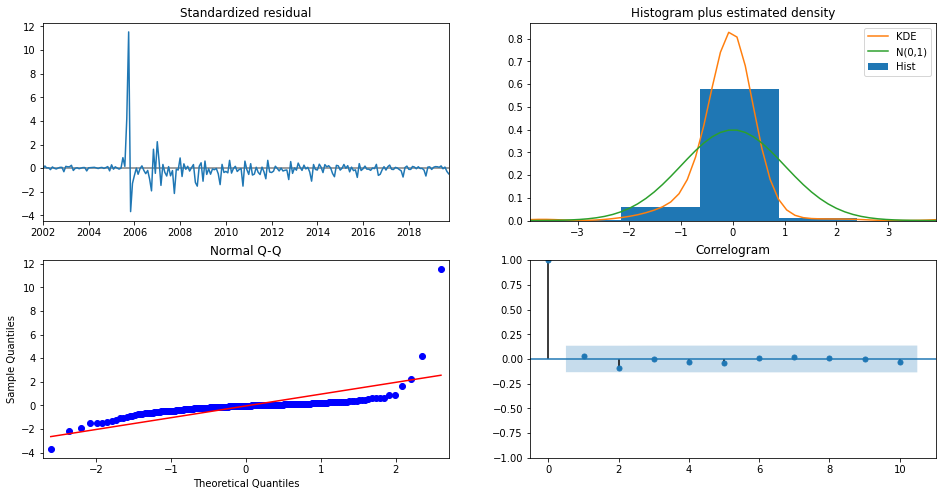

In [20]:
# Show training metrics
results.plot_diagnostics(figsize=(16, 8))
plt.show()

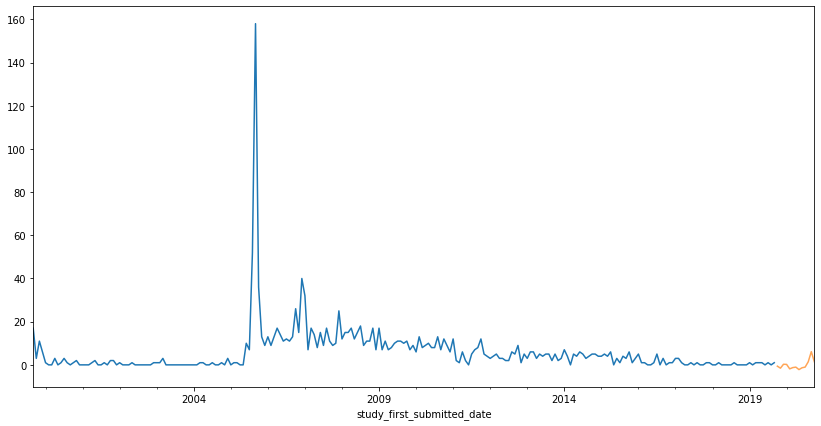

In [21]:
# Forecast one year
pred = results.get_prediction(start=pd.to_datetime('2019-10-17 00:00:00'), end=pd.to_datetime('2020-10-17 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))


In [22]:
# In pandas df, transform date time
result_clean['study_first_submitted_date'] = pd.to_datetime(result_clean['study_first_submitted_date'], format='%Y-%m-%d', errors='ignore')
result_clean.index=result_clean['study_first_submitted_date']
print(result_clean.dtypes)

name                                  object
study_first_submitted_date    datetime64[ns]
nct_id                                object
lead_or_collaborator                  object
dtype: object


/home/valerian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
# Group by year and count Chicago / Novartis
grouped_year = result_clean.groupby(by=[result_clean.index.year])[['name']].count()
print(grouped_year.shape)

Chicago = result_clean[result_clean['name'] == "University of Chicago"]
Novartis = result_clean[result_clean['name'] == "Novartis"]

Chicago = Chicago.groupby(by=[Chicago.index.year])[['name']].count()
Novartis = Novartis.groupby(by=[Novartis.index.year])[['name']].count()

x = pd.merge(Chicago, Novartis, on="study_first_submitted_date")
x.columns = ['Chicago', 'Novartis']
print(x)

(21, 1)
                            Chicago  Novartis
study_first_submitted_date                   
1999                             34         3
2000                              8         4
2001                              7         1
2003                              3         2
2004                              1         6
2005                             37       250
2006                             12       182
2007                             21       153
2008                             41       118
2009                             35        84
2010                             34        75
2011                             13        51
2012                             17        31
2013                             20        29
2014                             14        38
2015                             25        15
2016                              9         9
2019                              5         1


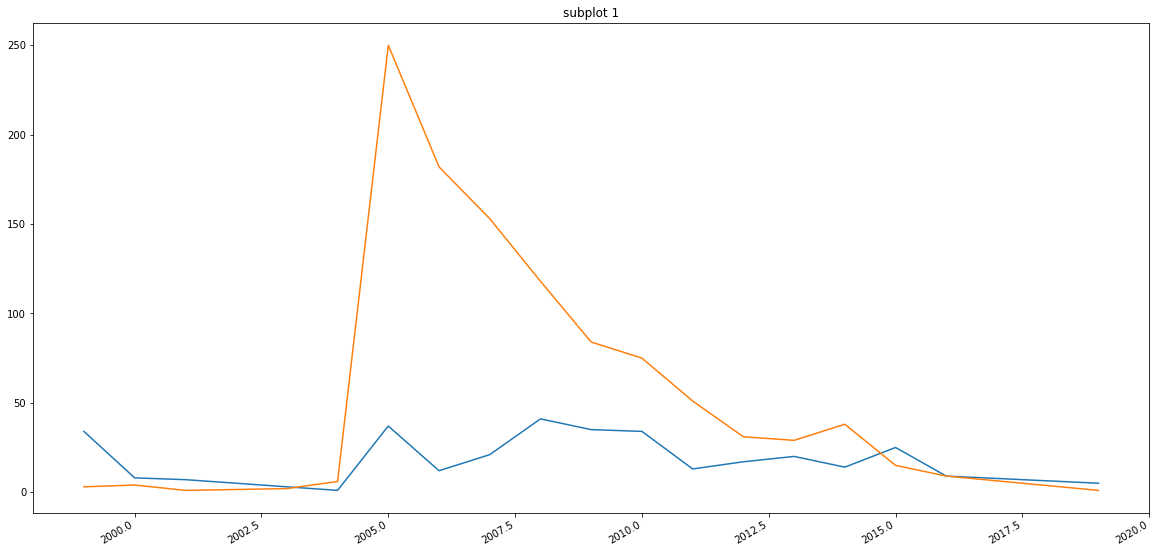

In [24]:
# Plot
plt.figure(figsize=(20,10))
plt.plot(x)
plt.title('subplot 1')
plt.gcf().autofmt_xdate()
plt.show()

In [25]:
# Show requested table
y = result_clean[['name','study_first_submitted_date', 'nct_id', 'lead_or_collaborator']]
y["Year"] = pd.DatetimeIndex(result_clean['study_first_submitted_date']).year

y.head()

,name,study_first_submitted_date,nct_id,lead_or_collaborator,Year
study_first_submitted_date,,,,,
2012-05-04,Novartis,2012-05-04,NCT01593748,collaborator,2012
2010-06-15,Novartis,2010-06-15,NCT01155817,collaborator,2010
2010-03-12,Novartis,2010-03-12,NCT01087008,collaborator,2010
2008-09-25,Novartis,2008-09-25,NCT00760981,collaborator,2008
2005-09-13,Novartis,2005-09-13,NCT00219739,collaborator,2005
